# Plot Array Configuration and Observation Plots

In [1]:
import os
import sys
import h5py
import numpy as np
from itertools import product
import astropy.units as u

import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

root = os.path.join(os.getcwd(), "../")
sys.path.append(root)

import antennas as ar

## Load Data

In [2]:
# get antenna list

tr_classes = ["EQ14", "EQ28"]
fields = ["A", "B", "C", "D", "E"]

trlist, trlist_xx, trlist_yy = [], [], []
trlist_fl_xx, trlist_fl_yy = [], []
jd_tr_flags = []
jd_lst_flags = []
jd_list = []
lst_list = []

for tr_class, field in product(tr_classes, fields):
    data_file = f"/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/{tr_class}_F{field}_B2.h5"
    
    with h5py.File(data_file) as f:
        trlist.append(f["triads"][()])
        trlist_xx.append(f["triads XX"][()])
        trlist_yy.append(f["triads YY"][()])
        nanflags = np.all(f["nan-flags"][()], axis=0)
        jd_tr_flags.append(f["JD-triad flags 2"][()] | nanflags)
        jd_tr_flags[-1] = np.array([jd_tr_flags[-1], jd_tr_flags[-1]])
        jd_list.append(f["JD"][()])
        jd_lst_flags.append(f["JD-LST flags"][()])
        lst_list.append(f["LST"][()])

for tr_class, field in product(tr_classes, fields):
    data_file = f"/lustre/aoc/projects/hera/pkeller/data/H1C_IDR3.2/sample/{tr_class}_F{field}_B2_AVG.h5"
    
    with h5py.File(data_file) as f:
        trlist_fl_xx.append(f["triads XX"][()])
        trlist_fl_yy.append(f["triads YY"][()])
        
ant_list = np.unique(np.concatenate(trlist, axis=0))
ant_list_xx = np.unique(np.concatenate(trlist_xx, axis=0))
ant_list_yy = np.unique(np.concatenate(trlist_yy, axis=0))
tr_list = np.unique(np.concatenate(trlist, axis=0), axis=0)
tr_list_xx = np.unique(np.concatenate(trlist_xx, axis=0), axis=0)
tr_list_yy = np.unique(np.concatenate(trlist_yy, axis=0), axis=0)

In [3]:
ant_path = "/lustre/aoc/projects/hera/pkeller/data/array/antenna_positions_350.dat"
ant_path_idr = "/lustre/aoc/projects/hera/pkeller/data/array/antlist_h1c_FE.dat"
ant_num_idr = np.loadtxt(ant_path_idr)

hera = ar.Array()
hera.read_ant_file(ant_path, antnum=False)
hera.ant_pos[:, 1] *= -1
hera.ant_diameter = 14

## Plot Array Configuration

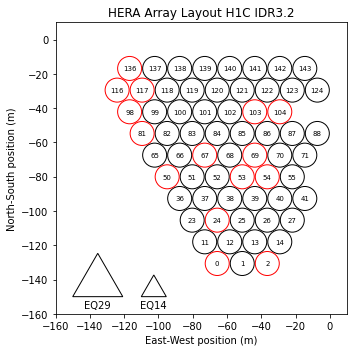

In [4]:
ant_list_xx = np.unique(np.concatenate(trlist_fl_xx, axis=0))
ant_list_yy = np.unique(np.concatenate(trlist_fl_yy, axis=0))
ant_list_used = np.unique(np.hstack([ant_list_xx, ant_list_yy]))
ant_list_not_used = ant_list[~np.in1d(ant_list, ant_list_used)]

fig, ax = plt.subplots(figsize=(5, 5))

hera.ant_flags = ~np.in1d(hera.ant_num, ant_list_used)
ax = hera.plot_antennas(ax=ax)

hera.ant_flags = False
hera.ant_flags = ~np.in1d(hera.ant_num, ant_list_not_used)
ax = hera.plot_antennas(ax=ax, color="r")

ax.set_xlim([-160, 10])
ax.set_ylim([-160, 10])
ax.set_title("HERA Array Layout H1C IDR3.2")

X1 = np.array([[0, 0], [14.6, 0], [7.3, 14.6 * np.sqrt(3 / 4)]]) - 150
X1[:, 0] += 40
t1 = plt.Polygon(X1, color="k", fill=False)

X2 = np.array([[0, 0], [29.2, 0], [14.6, 29.2 * np.sqrt(3 / 4)]]) - 150
t2 = plt.Polygon(X2, color="k", fill=False)

ax.text(-150 + 40 + 7.3, -155, "EQ14", va="center", ha="center")
ax.text(-150 + 14.6, -155, "EQ29", va="center", ha="center")

plt.gca().add_patch(t1)
plt.gca().add_patch(t2)

plt.tight_layout()
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/array_layout.pdf")
plt.show()

## Plot Number of Triad vs JD

In [5]:
jd_all = np.unique(np.concatenate(jd_list))

jd_tr_flags_combined_eq14 = np.ones((2, len(jd_all), 95)).astype(bool)
jd_tr_flags_combined_eq28 = np.ones((2, len(jd_all), 70)).astype(bool)

for i, jd in enumerate(jd_all):
    for jds, fl in zip(jd_list, jd_tr_flags):
        if jd in jds:
            idx = np.where(jd == jds)[0]
            if fl.shape[-1] == 95:
                jd_tr_flags_combined_eq14[:, i] &= fl[:, idx[0]]
            elif fl.shape[-1] == 70:
                jd_tr_flags_combined_eq28[:, i] &= fl[:, idx[0]]

jd_tr_flags_combined_eq14 = ~jd_tr_flags_combined_eq14.astype(bool)
jd_tr_flags_combined_eq28 = ~jd_tr_flags_combined_eq28.astype(bool)

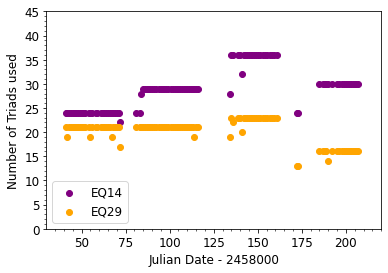

In [6]:
plt.rcParams['font.size'] = 12

Ntr_eq14 = np.nansum(jd_tr_flags_combined_eq14, axis=-1)
Ntr_eq28 = np.nansum(jd_tr_flags_combined_eq28, axis=-1)
idx_eq14 = np.where(Ntr_eq14 > 0)
idx_eq28 = np.where(Ntr_eq28 > 0)

fig, ax = plt.subplots(1, 1)
ax.scatter(jd_all[Ntr_eq14[0] > 0] - 2458000, Ntr_eq14[0][Ntr_eq14[0] > 0], marker="o", color="purple", label="EQ14")
ax.scatter(jd_all[Ntr_eq28[0] > 0] - 2458000, Ntr_eq28[0][Ntr_eq28[0] > 0], marker="o", color="orange", label="EQ29")

ax.set_xlim([30, 220])
ax.set_ylim([0, 45])
ax.set_xlabel("Julian Date - 2458000")
ax.set_ylabel("Number of Triads used")
ax.minorticks_on()
ax.legend(loc=3)
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/jd_ntr.pdf")

## Plot Number of Days vs LST

In [7]:
# only execute this cell once
lst_list[0] -= 24 

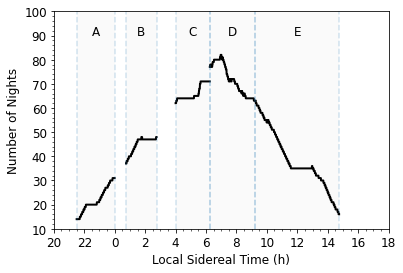

In [8]:
xticklabels = np.hstack([np.arange(20, 24, 2), np.arange(0, 19, 2)])

fig, ax = plt.subplots(1, 1)
boundaries = np.array([[-2.5, 0.0], [0.75, 2.75], [4.0, 6.25], [6.25, 9.25], [9.25, 14.75]])

for lst, fl, boundary, field in zip(lst_list, jd_lst_flags, boundaries, ["A", "B", "C", "D", "E"]):
    idx = np.where((lst >= boundary[0]) & (lst <= boundary[1]))
    ax.plot(lst[idx], (~fl).sum(0)[idx], linewidth=2, color="k")
    ax.text(np.mean(boundary), 90, field, ha="center")
    ax.axvspan(boundary[0], boundary[1], color='k', alpha=0.02, lw=0)
                              
ax.set_ylim([10, 100])
ax.set_xlim([-4, 18])
ax.set_xticks(np.arange(-4, 19, 2))
ax.set_xticklabels(xticklabels)
ax.set_xlabel("Local Sidereal Time (h)")
ax.set_ylabel("Number of Nights")

ax.vlines(boundaries.reshape(-1), 0, 100, alpha=0.2, linestyle="dashed")

ax.minorticks_on()
plt.savefig("/users/pkeller/code/H1C_IDR3.2/plots/lst_njd.pdf")